In [1]:
# Setup
import pandas as pd
import numpy as np
import git
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
import glob
from torch.nn.utils.rnn import pad_sequence

# path to 3D joint features 
path1 = os.path.expanduser('~/MPS-Net_release/output/3d_joints/*.npy')
joint3d_feature_files = glob.glob(path1)

# file names
file_names = [os.path.splitext(os.path.basename(file))[0] for file in joint3d_feature_files]

# A list of numpy arrays 
joint3d_features = [np.load(file) for file in joint3d_feature_files]

# Convert from numpy arrays to tensors
joint3d_features_tensors = [torch.from_numpy(arr) for arr in joint3d_features]

# Pad since each numpy array has different sizes
joint3d_features_padded = pad_sequence(joint3d_features_tensors, batch_first=True) 

# print(len(file_names))      # 383
# print(joint3d_features[0].shape)   # (num_frames, 49, 3)

# print(joint3d_features_padded[0].shape)    # torch.Size([num_frames, 49, 3])

In [6]:
# Flatten and convert to DataFrame 

# First, convert Pytorch tensor to numpy array
joint3d_features_np = joint3d_features_padded.numpy()

# Flatten each feature into a single row 
num_samples = joint3d_features_np.shape[0]
joint3d_features_np = joint3d_features_np.reshape((num_samples, -1))

# print(joint3d_features_np.shape)       # (383, 121569)

# Convert to DataFrame
joint3d_features_df = pd.DataFrame(joint3d_features_np)

# Insert names of videos 
joint3d_features_df.insert(0, 'subjectid', file_names)

joint3d_features_df

,subjectid,0,1,2,3,4,5,6,7,8,...,121559,121560,121561,121562,121563,121564,121565,121566,121567,121568
0,mYXJQupd,0.027826,-0.780049,-0.115790,-0.058443,-0.693392,0.023770,-0.173167,-0.620746,-0.075756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ytlu6T69,0.196798,-0.719733,-0.184370,0.027793,-0.653067,-0.133092,-0.004578,-0.523414,-0.264216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ucT4dryZ,0.064690,-0.820248,-0.106564,-0.070640,-0.696380,-0.044875,-0.110532,-0.590362,-0.193918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Di0gPE0H,0.129474,-0.769256,-0.279999,0.007787,-0.668521,-0.161427,-0.093351,-0.542099,-0.249047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,bePyG1Du,-0.165369,-0.710608,-0.246707,-0.030127,-0.648202,-0.128993,-0.150376,-0.591207,-0.008985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,yKdKYz23,-0.031680,-0.725516,-0.197813,0.023305,-0.677157,-0.022222,-0.122985,-0.604568,0.046824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,a6j4D1CL,0.049149,-0.789110,-0.144419,-0.086988,-0.694909,-0.054479,-0.136264,-0.588434,-0.188640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,NCmOpQMW,0.157545,-0.743996,-0.238464,0.001282,-0.654638,-0.165801,-0.070121,-0.524422,-0.261685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,ZR3QAZmu,0.111881,-0.745201,-0.136528,-0.012442,-0.675288,-0.008861,-0.161357,-0.593940,-0.063020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Load survey data
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


In [8]:
# joint dataframes by subjectid
df_join = joint3d_features_df.set_index('subjectid').join(df_survey.set_index('subjectid'), how='inner')
df_join

,0,1,2,3,4,5,6,7,8,9,...,121560,121561,121562,121563,121564,121565,121566,121567,121568,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
mYXJQupd,0.027826,-0.780049,-0.115790,-0.058443,-0.693392,0.023770,-0.173167,-0.620746,-0.075756,-0.113216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Ytlu6T69,0.196798,-0.719733,-0.184370,0.027793,-0.653067,-0.133092,-0.004578,-0.523414,-0.264216,0.007293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ucT4dryZ,0.064690,-0.820248,-0.106564,-0.070640,-0.696380,-0.044875,-0.110532,-0.590362,-0.193918,-0.041058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Di0gPE0H,0.129474,-0.769256,-0.279999,0.007787,-0.668521,-0.161427,-0.093351,-0.542099,-0.249047,0.030009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
bePyG1Du,-0.165369,-0.710608,-0.246707,-0.030127,-0.648202,-0.128993,-0.150376,-0.591207,-0.008985,-0.239467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yKdKYz23,-0.031680,-0.725516,-0.197813,0.023305,-0.677157,-0.022222,-0.122985,-0.604568,0.046824,-0.227372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
a6j4D1CL,0.049149,-0.789110,-0.144419,-0.086988,-0.694909,-0.054479,-0.136264,-0.588434,-0.188640,0.037399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
NCmOpQMW,0.157545,-0.743996,-0.238464,0.001282,-0.654638,-0.165801,-0.070121,-0.524422,-0.261685,0.047762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [10]:
NUM_TRAIN = len(train_indices)      # 305
NUM_VAL = len(val_indices)          # 39
NUM_TEST = len(test_indices)        # 39

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [11]:
# Check for number of OA positive and number of samples in the dataset
print(df_join['OA_check'].count())  
print(df_join['OA_check'].sum())    
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 94% training accuracy
print(train_data['OA_check'].count())  
print(train_data['OA_check'].sum())    

# Validation set - This implies that if the model always predicts 0, it would have 94% val accuracy
print(val_data['OA_check'].count()) 
print(val_data['OA_check'].sum())   

# Test set - This implies that if the model always predicts 0, it would have 94% test accuracy
print(test_data['OA_check'].count()) 
print(test_data['OA_check'].sum()) 

383
24
305
20
39
2
39
2


In [12]:
# Skip Normalization

In [13]:
# Create DataLoaders

# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

In [14]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 121569]) torch.Size([64])
tensor([[ 0.0407, -0.7887, -0.0679,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2595, -0.7194, -0.2637,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0905, -0.7443, -0.2085,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0878, -0.7713, -0.2317,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2044, -0.6112, -0.3198,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1453, -0.7482, -0.2712,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**# Create dataloaders with upsampling**

In [15]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
# _, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

In [16]:
train = CustomDataset(dataframe=train_data, transform=None)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

# _, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

**# Barebones Model**

Train model with unnormalized inputs, no oversampling

In [18]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 121569
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 0.4365, train_acc = 93.4426, val_acc = 94.8718, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = 0.2499, train_acc = 92.4590, val_acc = 89.7436, train_pos = 2.2951, val_pos = 10.2564
Epoch 2, loss = 0.1014, train_acc = 93.1148, val_acc = 94.8718, train_pos = 3.6066, val_pos = 0.0000
Epoch 3, loss = 0.2938, train_acc = 93.7705, val_acc = 94.8718, train_pos = 0.3279, val_pos = 0.0000
Epoch 4, loss = 0.1435, train_acc = 94.4262, val_acc = 94.8718, train_pos = 0.9836, val_pos = 0.0000
Epoch 5, loss = 0.1834, train_acc = 94.4262, val_acc = 94.8718, train_pos = 0.9836, val_pos = 0.0000
Epoch 6, loss = 0.1060, train_acc = 95.0820, val_acc = 92.3077, train_pos = 1.6393, val_pos = 2.5641
Epoch 7, loss = 0.0920, train_acc = 95.0820, val_acc = 94.8718, train_pos = 1.6393, val_pos = 0.0000
Epoch 8, loss = 0.0806, train_acc = 95.0820, val_acc = 92.3077, train_pos = 1.6393, val_pos = 2.5641
Epoch 9, loss = 0.1266, train_acc = 96.0656, val_acc = 94.8718, train_pos = 2.6230, val_po

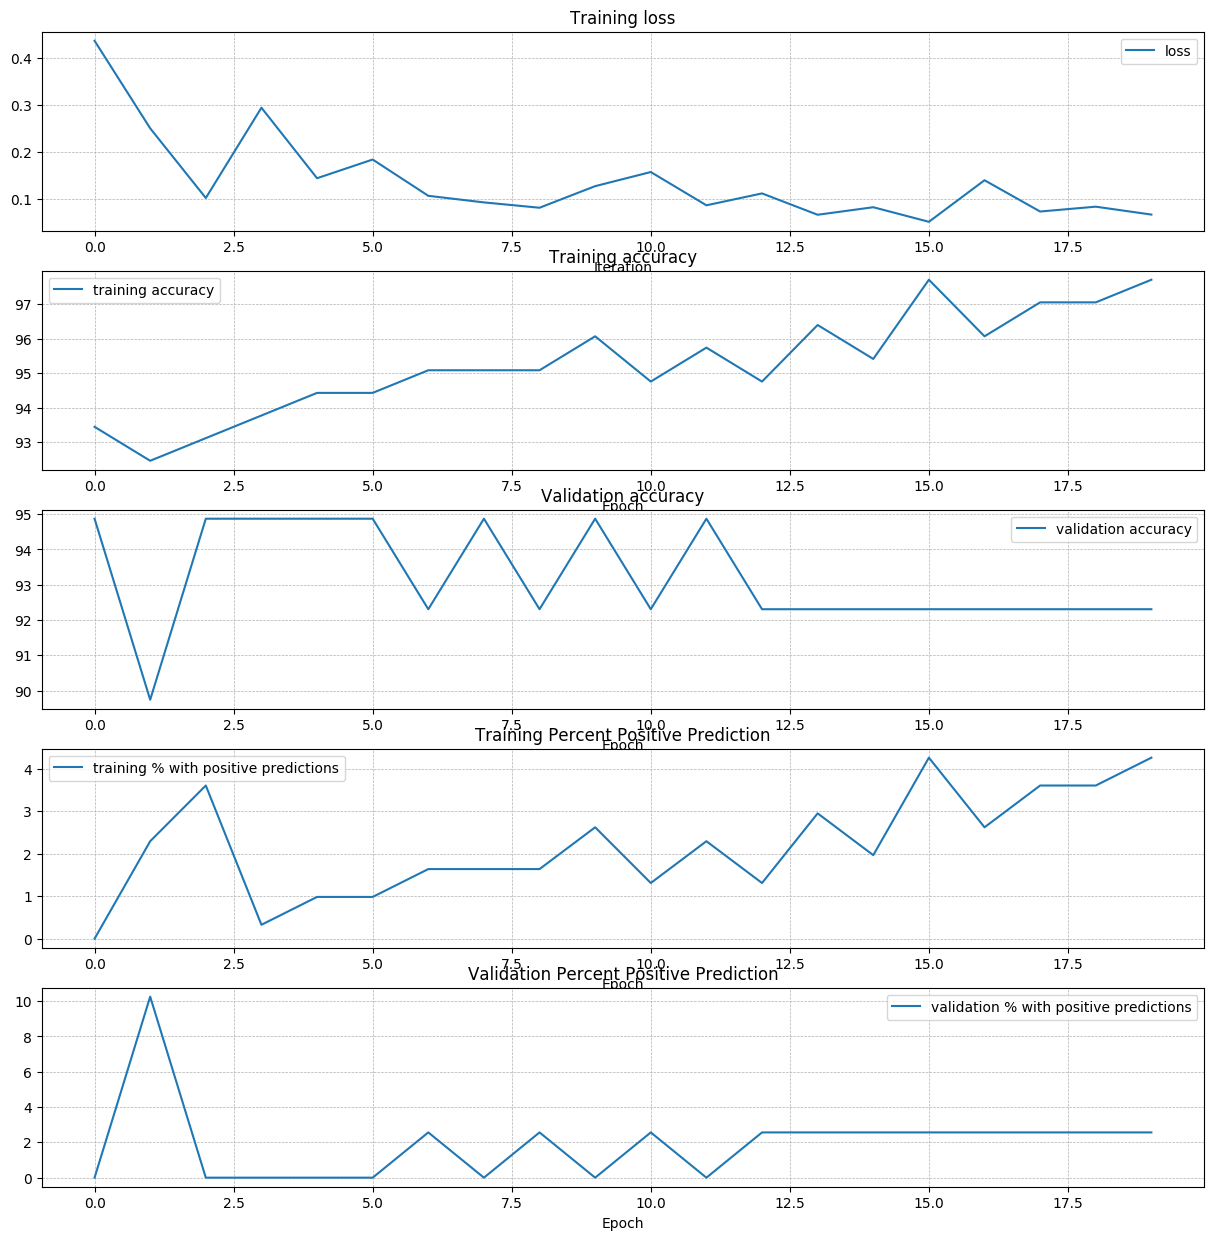

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

Train model with unnormalized inputs, with oversampling

In [21]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 121569
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 1.7519, train_acc = 58.0328, val_acc = 89.7436, train_pos = 37.3770, val_pos = 10.2564
Epoch 1, loss = 1.2665, train_acc = 60.9836, val_acc = 84.6154, train_pos = 53.4426, val_pos = 20.5128
Epoch 2, loss = 0.8788, train_acc = 68.8525, val_acc = 89.7436, train_pos = 19.6721, val_pos = 5.1282
Epoch 3, loss = 0.5365, train_acc = 74.7541, val_acc = 82.0513, train_pos = 36.3934, val_pos = 23.0769
Epoch 4, loss = 0.4035, train_acc = 83.6066, val_acc = 92.3077, train_pos = 49.1803, val_pos = 2.5641
Epoch 5, loss = 0.2726, train_acc = 79.0164, val_acc = 89.7436, train_pos = 33.1148, val_pos = 10.2564
Epoch 6, loss = 0.3551, train_acc = 92.1311, val_acc = 89.7436, train_pos = 64.5902, val_pos = 10.2564
Epoch 7, loss = 0.3566, train_acc = 86.5574, val_acc = 89.7436, train_pos = 38.6885, val_pos = 5.1282
Epoch 8, loss = 0.2656, train_acc = 90.1639, val_acc = 89.7436, train_pos = 41.6393, val_pos = 5.1282
Epoch 9, loss = 0.2211, train_acc = 91.8033, val_acc = 89.7436, train_pos = 4

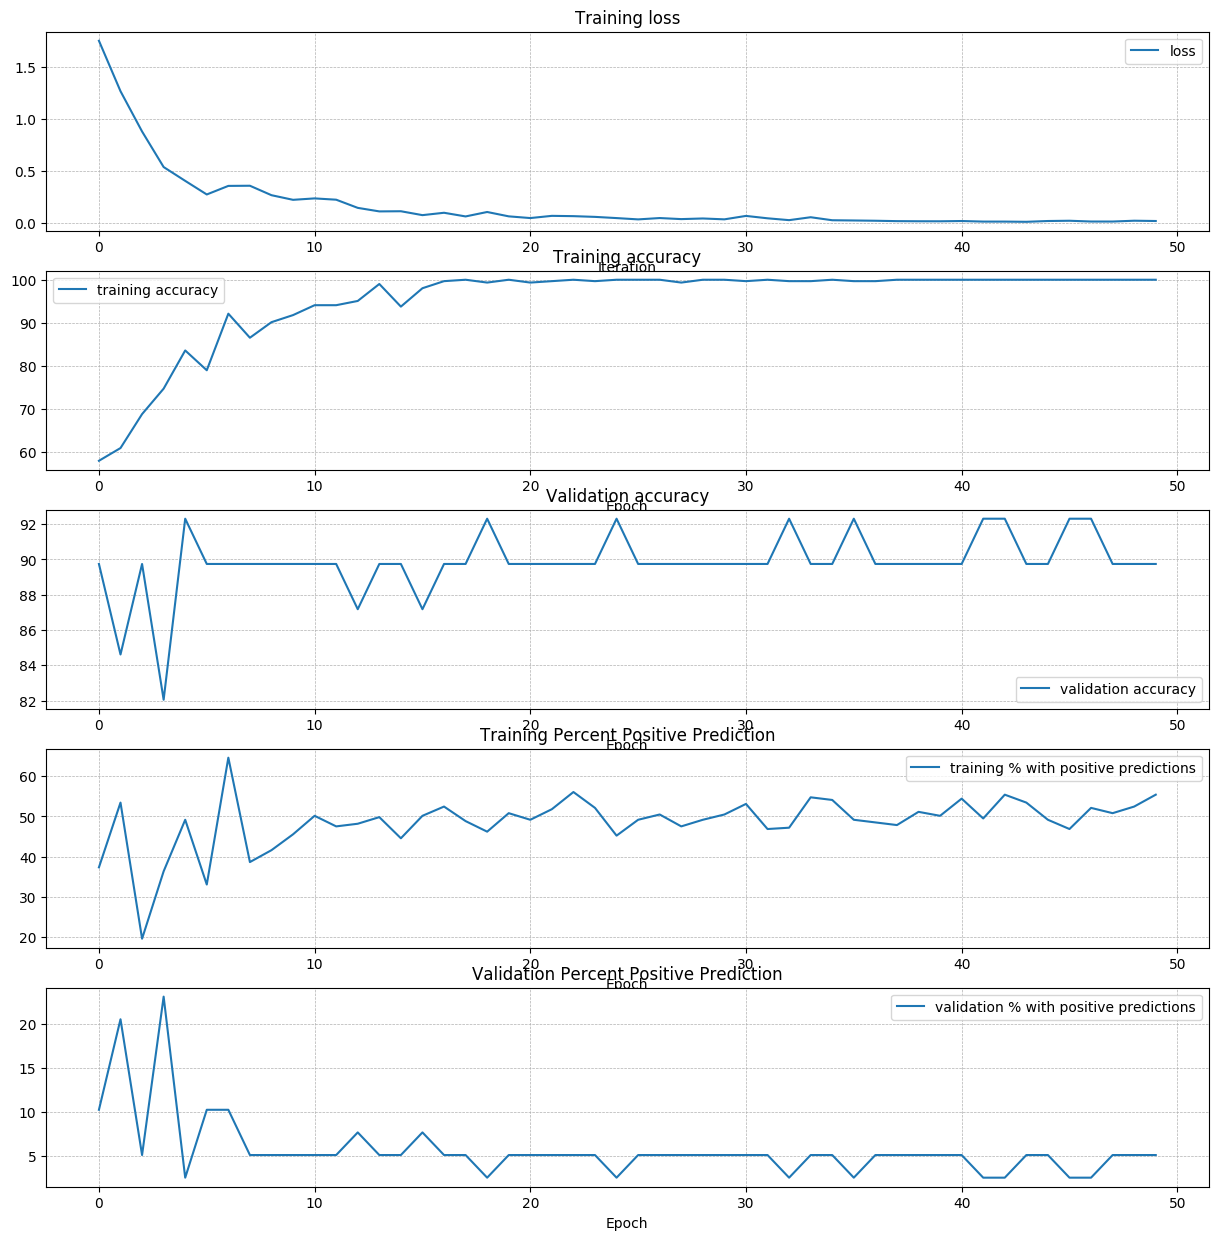

In [22]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

Train model with unnormalized inputs, no oversampling, with weighted loss

In [23]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 121569
hidden_size = 2000
num_classes = 1
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

Epoch 0, loss = 2.0494, train_acc = 66.2295, val_acc = 69.2308, train_pos = 31.1475, val_pos = 35.8974
Epoch 1, loss = 0.6272, train_acc = 79.3443, val_acc = 84.6154, train_pos = 20.6557, val_pos = 15.3846
Epoch 2, loss = 0.8612, train_acc = 79.6721, val_acc = 76.9231, train_pos = 19.6721, val_pos = 23.0769
Epoch 3, loss = 1.0468, train_acc = 79.3443, val_acc = 89.7436, train_pos = 23.9344, val_pos = 5.1282
Epoch 4, loss = 0.6764, train_acc = 86.8852, val_acc = 92.3077, train_pos = 16.3934, val_pos = 2.5641
Epoch 5, loss = 0.6127, train_acc = 97.3770, val_acc = 92.3077, train_pos = 5.9016, val_pos = 7.6923
Epoch 6, loss = 0.2828, train_acc = 88.1967, val_acc = 94.8718, train_pos = 18.3607, val_pos = 0.0000
Epoch 7, loss = 0.5189, train_acc = 96.0656, val_acc = 89.7436, train_pos = 7.8689, val_pos = 5.1282
Epoch 8, loss = 0.1134, train_acc = 96.0656, val_acc = 94.8718, train_pos = 9.8361, val_pos = 0.0000
Epoch 9, loss = 0.2819, train_acc = 96.3934, val_acc = 89.7436, train_pos = 8.1967

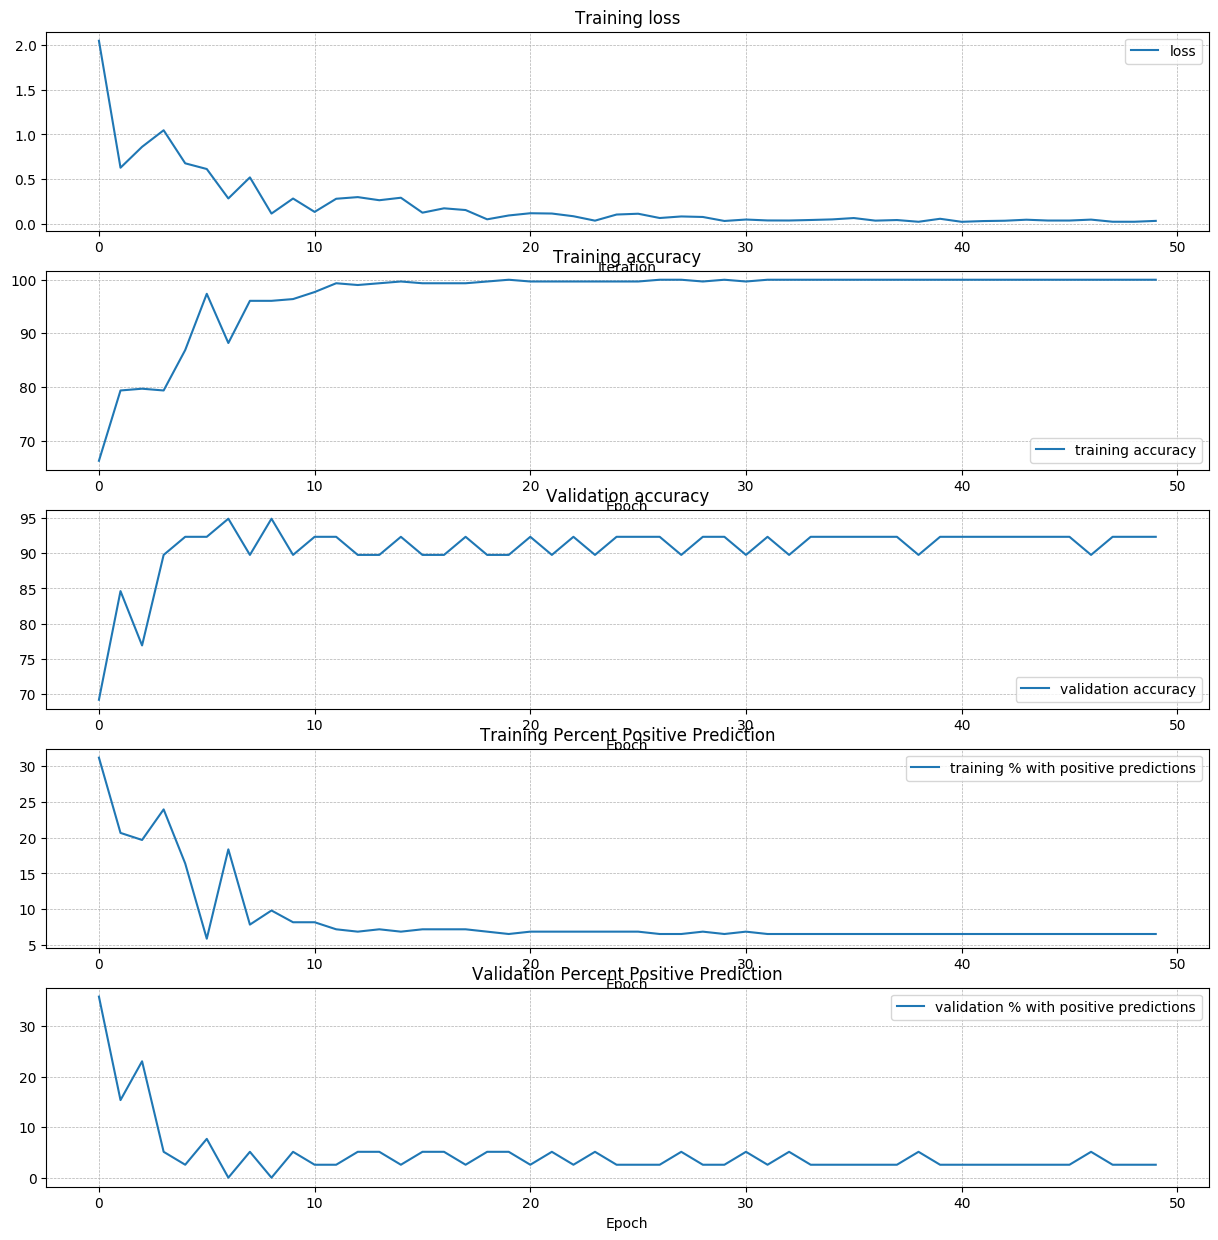

In [24]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()